In [72]:

from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from os import listdir
from PIL import Image
import glob, os

from os.path import isfile, join
import numpy as np
from pandas import DataFrame
import pandas as pd
from matplotlib import pyplot as plt
#from __future__ import print_function

from SRC.transform import *
#estas son mis funciones traidas del jupyter contiguo

In [73]:
paths={"black":"INPUT/black/",
      "white":"INPUT/white/",
      "green":"INPUT/green/",
      "red":"INPUT/red/"}
images={}
for color,path in paths.items():
    images[color]=[]
    for im in listdir(path):
        if im.endswith("jpg"):
            #size=(64,64)
            a=resize_image(path+im,(64,64))
            images[color].append(np.asarray(a))
    images[color]=np.array(images[color])

In [74]:
X= np.concatenate(list(images.values()),axis=0)
y = np.concatenate([[k]* v.shape[0] for k,v in images.items()])

# Division entre la x y la y para test
### Ojo, normalmente convertiriamos el onehotencoder antes de esta division para ahorrarnos un paso

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [76]:
img_width, img_height = 64, 64
img_rows, img_cols = 64, 64

# Prepare data to feed the NN
num_classes = 4

# Ask keras which format to use depending on used backend and arrange data as expected
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_width, img_height)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_width, img_height, 3)

# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = tf.keras.utils.normalize(X_train,axis=1)
X_test = tf.keras.utils.normalize(X_test,axis=1)
#X_train = X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (8388, 64, 64, 3)
8388 train samples
2097 test samples


In [77]:
#red neuronal propiamente dicha

In [78]:
img_width, img_height = 64, 64

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.Flatten())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Proceso de cambio de las y para poder utilizarlas en el modelo. 
### Las necesitamos en el formato de array sin strings y getdummies no nos sirvio ya que 
### no podiamos obtener el color con posterioridad.

In [79]:
# importo aqui para que quede reflejado el modulo que utilizamos
from sklearn.preprocessing import OneHotEncoder

In [80]:
y_test


array(['white', 'black', 'white', ..., 'white', 'white', 'white'],
      dtype='<U5')

In [81]:
# Hacemos el reshape, luego onehot encoder, luego fit y por ultimo toarray
y_test= y_test.reshape(-1, 1)
y_test

array([['white'],
       ['black'],
       ['white'],
       ...,
       ['white'],
       ['white'],
       ['white']], dtype='<U5')

In [82]:
##3
enc = OneHotEncoder()
enc.fit(y_test)  

OneHotEncoder()

In [83]:
y_test = enc.transform(y_test).toarray()

In [84]:
#por fin y_test esta en la forma que queremos
y_test


array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [17]:
#ahora hago lo mismo con y Y_train

In [85]:
y_train

array(['white', 'white', 'black', ..., 'black', 'black', 'red'],
      dtype='<U5')

In [86]:
y_train= y_train.reshape(-1, 1)

In [87]:
enc = OneHotEncoder()
enc.fit(y_train)  

OneHotEncoder()

In [88]:
y_train = enc.transform(y_train).toarray()

In [89]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [23]:
#ha funcionado. Tenemos y_test e y_train en el formato que necesitabamos
# podiamos haberlo hecho antes de dividir el split del train pero he decidido hacerlo dos veces para practicar

In [90]:
enc.get_feature_names()

array(['x0_black', 'x0_green', 'x0_red', 'x0_white'], dtype=object)

In [91]:
enc.inverse_transform([[0,1,0,0]])

array([['green']], dtype='<U5')

In [26]:
# Codigo para para correr el modelo de red neuronal. 

In [92]:
batch_size = 100
epochs = 20

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))



Epoch 1/20
84/84 [==============================] - 12s 138ms/step - loss: 0.3558 - accuracy: 0.6845 - val_loss: 0.2211 - val_accuracy: 0.8398
Epoch 2/20
84/84 [==============================] - 13s 151ms/step - loss: 0.2072 - accuracy: 0.8526 - val_loss: 0.1273 - val_accuracy: 0.9113
Epoch 3/20
84/84 [==============================] - 14s 166ms/step - loss: 0.1492 - accuracy: 0.9007 - val_loss: 0.0861 - val_accuracy: 0.9409
Epoch 4/20
84/84 [==============================] - 14s 164ms/step - loss: 0.1083 - accuracy: 0.9309 - val_loss: 0.0959 - val_accuracy: 0.9285
Epoch 5/20
84/84 [==============================] - 14s 167ms/step - loss: 0.0868 - accuracy: 0.9459 - val_loss: 0.0481 - val_accuracy: 0.9704
Epoch 6/20
84/84 [==============================] - 14s 166ms/step - loss: 0.0742 - accuracy: 0.9553 - val_loss: 0.0409 - val_accuracy: 0.9714
Epoch 7/20
84/84 [==============================] - 14s 167ms/step - loss: 0.0639 - accuracy: 0.9586 - val_loss: 0.0374 - val_accuracy: 0.9738

In [36]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [37]:
model.save("model.cars_colours")
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.cars_colours/assets
Saved model to disk


In [25]:
# PRUEBAS

In [38]:
X_test[45].shape
model.predict(np.array([X_test[2000]]))
#nos dice cual es la prediccion del modelo

array([[9.9991882e-01, 3.6719746e-06, 1.0766612e-06, 1.0204652e-10]],
      dtype=float32)

In [39]:
enc.get_feature_names()
# y hay que recordar que los colores marcados son:

array(['x0_black', 'x0_green', 'x0_red', 'x0_white'], dtype=object)

In [40]:
enc.inverse_transform([[9.9999976e-01, 6.4836332e-09, 1.1157968e-09, 1.2618054e-12]])
#nos da el resultado mas probable en una tuple. 


array([['black']], dtype='<U5')

In [41]:
X_test[2000].shape

(64, 64, 3)

In [42]:
model.predict(np.array([X_test[2000]]))

array([[9.9991882e-01, 3.6719746e-06, 1.0766612e-06, 1.0204652e-10]],
      dtype=float32)

In [43]:
enc.inverse_transform([[9.9999976e-01, 6.4836332e-09, 1.1157968e-09, 1.2618054e-12]])[0][0]
# le digo que me muestre solo el primer elemento, que es el color

'black'

In [44]:
X_test[2000].size

12288

In [45]:
model.predict(np.array([X[5000]]))

array([[0., 0., 0., 1.]], dtype=float32)

In [ ]:


# PRUEBA CON COCHE AJENO AL DATASET

In [46]:
# creo que ya estan todos importados pero por si acaso

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

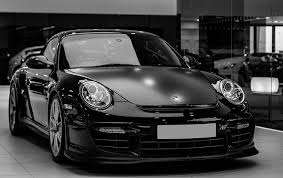

In [64]:
imgfelipe=Image.open("INPUT/fotocochesinternet/14.jpeg")
imgfelipe

In [65]:
imgfelipe = imgfelipe.resize((64,64))

In [66]:
imgfelipe=np.expand_dims(np.array(imgfelipe),0)

In [67]:
imgfelipe=tf.keras.utils.normalize(imgfelipe,axis=1) 

In [68]:
model.predict(imgfelipe)

array([[1.9409228e-04, 1.1526601e-02, 3.8087537e-06, 9.8305511e-01]],
      dtype=float32)

In [69]:
pred= model.predict(np.array(imgfelipe))

In [70]:
c = enc.inverse_transform(pred)
prob = max(pred[0])

In [71]:
res = c[0,0],prob
res

('white', 0.9830551)

In [169]:
# Buscar en doc como guardar el modelo entrenado (Guardar todo el modelo o los pesos solo) OK
# En un nuevo fichero (jupyter o .py), cargar el modelo. OK
# Crear funcion predict_color(path) => (color, prob) OK
# Crear funcion a parte que te lo ponga bonito, recibiendo el output de predict_color() OK